In [1]:
import h5py

with h5py.File('/Users/celery/Research/dataset/ABCD/abcd_DK_RSFC.mat', 'r') as f:
    print(list(f.keys()))
    print("\n")
    rsfc = f['abcd_RSFC_DK']
    ids = f['id_ndar_qc'][:]
    print("Subject ID:", ids[0])
    print("RSFC shape for this subject:", rsfc[0].shape)
    print("Data shape", rsfc.shape)



['#refs#', '#subsystem#', 'DiceIndex', 'ES', 'ErrID', 'ErrSession', 'ROIsID', 'abcd_Headmotion', 'abcd_RSFC_DK', 'abcd_rfMRI_bl_headmotion_qc', 'hm2ndar', 'id_ndar_qc', 'screener', 'sessionCode']


Subject ID: [<HDF5 object reference> <HDF5 object reference> <HDF5 object reference>
 ... <HDF5 object reference> <HDF5 object reference>
 <HDF5 object reference>]
RSFC shape for this subject: (68, 68)
Data shape (4199, 68, 68)


[[ 1.         -0.09472264  0.12228926 ...  0.09787289 -0.13379136
  -0.02815348]
 [-0.09472264  1.         -0.11542948 ... -0.22656102  0.29550642
   0.56612736]
 [ 0.12228926 -0.11542949  1.         ... -0.15201312  0.05918628
  -0.03397094]
 ...
 [ 0.09787289 -0.22656102 -0.15201312 ...  1.         -0.14486337
  -0.09531327]
 [-0.13379133  0.2955064   0.05918628 ... -0.14486337  1.
   0.48110753]
 [-0.02815347  0.56612736 -0.03397093 ... -0.09531327  0.48110753
   1.        ]]
<class 'numpy.ndarray'>


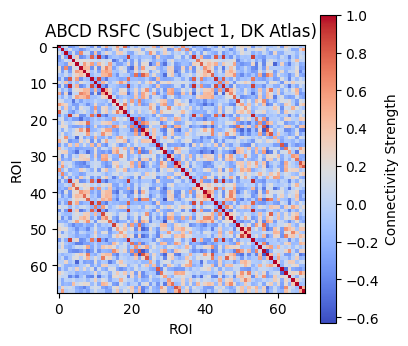

In [2]:
import h5py
import matplotlib.pyplot as plt
import numpy as np

# Load RSFC for one subject
with h5py.File('/Users/celery/Research/dataset/ABCD/abcd_DK_RSFC.mat', 'r') as f:
    rsfc = f['abcd_RSFC_DK'][1]  # second subject's 68x68 matrix
    print(rsfc)
    print(type(rsfc))
# Plot as heatmap
plt.figure(figsize=(4, 4))
plt.imshow(rsfc, cmap='coolwarm', interpolation='nearest')
plt.colorbar(label='Connectivity Strength')
plt.title('ABCD RSFC (Subject 1, DK Atlas)')
plt.xlabel('ROI')
plt.ylabel('ROI')
plt.show()


In [3]:
import h5py
import numpy as np

def _arr_to_string(arr):
    arr = np.asarray(arr)
    if arr.size == 0:
        return ''
    if arr.dtype.kind in ('u', 'i'):  # numeric char codes (maybe uint8 or uint16)
        vals = arr.flatten()
        # drop trailing zeros
        vals = vals[vals != 0]
        try:
            return ''.join(chr(int(v)) for v in vals)
        except Exception:
            # try interpreting as uint16 (UTF-16)
            try:
                vals16 = arr.astype('uint16').flatten()
                vals16 = vals16[vals16 != 0]
                return ''.join(chr(int(v)) for v in vals16)
            except Exception:
                return ''.join(map(str, vals))
    if arr.dtype.kind in ('S', 'U'):  # bytes / unicode
        parts = []
        for e in arr.flatten():
            if isinstance(e, bytes):
                try:
                    parts.append(e.decode('utf-8'))
                except Exception:
                    parts.append(e.decode('latin1', errors='ignore'))
            else:
                parts.append(str(e))
        return ''.join(parts)
    return str(arr)

def read_id_ndar_qc(mat_path, id_key='id_ndar_qc'):
    ids = []
    with h5py.File(mat_path, 'r') as f:
        refs_ds = f[id_key]
        refs = refs_ds[:]              # read dataset (may contain object refs or arrays)
        flat = refs.reshape(-1)       # flatten regardless of shape

        for i, r in enumerate(flat):
            # unwrap numpy arrays that wrap the real reference
            if isinstance(r, np.ndarray):
                # if it's actually a char-array already, decode it
                if r.dtype.kind in ('u', 'i', 'S', 'U'):
                    ids.append(_arr_to_string(r))
                    continue
                # otherwise try to unwrap a single-element array
                if r.size == 1:
                    r = r.reshape(-1)[0]
                else:
                    # fallback decode attempt
                    try:
                        ids.append(_arr_to_string(r))
                        continue
                    except Exception:
                        r = r.reshape(-1)[0]

            # now r is hopefully an h5py Reference, bytes, or a string-like name
            try:
                if isinstance(r, h5py.Reference) or type(r).__name__ == 'Reference':  # conservative check
                    ds = f[r]
                    data = ds[:]
                    ids.append(_arr_to_string(data))
                elif isinstance(r, (bytes, str)):
                    name = r.decode('utf-8') if isinstance(r, bytes) else r
                    # If the name points to a dataset, read & decode; otherwise just append the name
                    if name in f:
                        ids.append(_arr_to_string(f[name][:]))
                    else:
                        ids.append(name)
                else:
                    # last resort: try to interpret numeric arrays/values as char codes
                    try:
                        ids.append(_arr_to_string(np.array(r)))
                    except Exception as e:
                        # if we can't decode, append None and print a warning
                        print(f'Warning: could not decode element {i} (type={type(r)}).')
                        ids.append(None)
            except Exception as err:
                print(f'Warning: failed to dereference element {i}: {err!r}')
                ids.append(None)

    return ids

# Usage:
matfile = '/Users/celery/Research/dataset/ABCD/abcd_DK_RSFC.mat'
ids = read_id_ndar_qc(matfile)
print(ids)
print(len(ids))




['NDARINV003RTV85', 'NDARINV007W6H7B', 'NDARINV00HEV6HB', 'NDARINV00J52GPG', 'NDARINV00LH735Y', 'NDARINV00NPMHND', 'NDARINV00R4TXET', 'NDARINV00U4FTRU', 'NDARINV01AJ15N9', 'NDARINV01ELX9L6', 'NDARINV01NAYMZH', 'NDARINV01RGTWD2', 'NDARINV01Z8HAPV', 'NDARINV021403LF', 'NDARINV022ZVCT8', 'NDARINV028D3ELL', 'NDARINV02EBX0JJ', 'NDARINV02UVMTY7', 'NDARINV03BDCNWM', 'NDARINV03CV8RDT', 'NDARINV03NW0RKL', 'NDARINV03XVEBPM', 'NDARINV040B4TRC', 'NDARINV04EUBGTM', 'NDARINV04GAB2AA', 'NDARINV04JY6730', 'NDARINV059VLAHF', 'NDARINV05ATJ1V1', 'NDARINV05CA3VX5', 'NDARINV05X0LM1N', 'NDARINV05YY477E', 'NDARINV06A9DLE9', 'NDARINV06DE9Y0L', 'NDARINV06WHVUPX', 'NDARINV07BR8GMY', 'NDARINV07K2M5P4', 'NDARINV07RAHHYH', 'NDARINV07XG8391', 'NDARINV085CYDEZ', 'NDARINV08DNLREC', 'NDARINV08J0E48V', 'NDARINV08K0R9C4', 'NDARINV08K8VF33', 'NDARINV08R2PTT1', 'NDARINV08YFFYY2', 'NDARINV095EVLDD', 'NDARINV09AEBLZH', 'NDARINV09AUXBBT', 'NDARINV09ZE6UUK', 'NDARINV0A4P0LWM', 'NDARINV0A6WVRZY', 'NDARINV0A87RKWD', 'NDARINV0A9

In [41]:
from scipy.io import loadmat

file_path = "/Users/celery/Research/dataset/ABCD/indv_matfile/NDARINV007W6H7B_dk_correlation.mat"
#this is the second subject, compare this to the matrix printed above
data = loadmat(file_path)

print(data.keys())  # List variables
corr = data["correlation"]  # Access your matrix
print(corr)


dict_keys(['__header__', '__version__', '__globals__', 'correlation'])
[[ 1.         -0.09472264  0.12228926 ...  0.09787289 -0.13379136
  -0.02815348]
 [-0.09472264  1.         -0.11542948 ... -0.22656102  0.29550642
   0.56612736]
 [ 0.12228926 -0.11542949  1.         ... -0.15201312  0.05918628
  -0.03397094]
 ...
 [ 0.09787289 -0.22656102 -0.15201312 ...  1.         -0.14486337
  -0.09531327]
 [-0.13379133  0.2955064   0.05918628 ... -0.14486337  1.
   0.48110753]
 [-0.02815347  0.56612736 -0.03397093 ... -0.09531327  0.48110753
   1.        ]]
